In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import matplotlib as plt

In [3]:
import spatialdm as sdm
import spatialdm.plottings as pl

In [4]:
import squidpy as sq

/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()


  0%|          | 0/1000 [00:00<?, ?/s]

/home/dbdimitrov/.local/lib/python3.8/site-packages/squidpy/pl/_graph.py:239: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = AnnData(X=array, obs={cluster_key: pd.Categorical(adata.obs[cluster_key].cat.categories)})


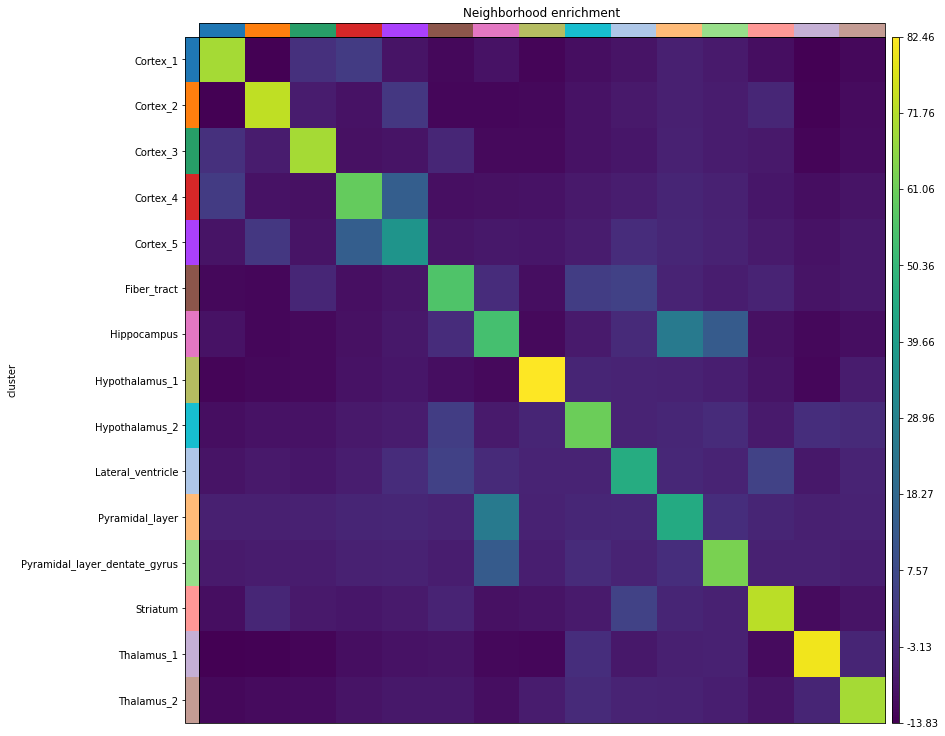

In [6]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="cluster")
sq.pl.nhood_enrichment(adata, cluster_key="cluster")

Set up

In [7]:
## SpatialDM tutorial data
# adata = sdm.datasets.melanoma()
# raw = pd.DataFrame(adata.raw.X, index=adata.obs_names, columns=adata.raw.var_names)
# log = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

In [8]:
raw = pd.DataFrame(adata.raw.X.todense(), index=adata.obs_names, columns=adata.raw.var_names)
log = pd.DataFrame(adata.X.todense(), index=adata.obs_names, columns=adata.var_names)

In [9]:
spatialcoord = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, columns=['x','y'])

In [10]:
# Preprocessing
my_sample = sdm.SpatialDM(log, raw, spatialcoord)     # load spatial data with simply log, raw, spatial input

In [11]:
my_sample.extract_lr(species='mouse', min_cell=3)

We set radial basis kernel parameter l = 1.2, and trimmed all weights < 0.2 (cutoff) to match the normal range of CCC (200 micrometers, 1 spot away from the sender cell here)

In [12]:
?my_sample.weight_matrix

Signature:
my_sample.weight_matrix(
    l,
    cutoff=None,
    n_neighbors=None,
    single_cell=False,
)
Docstring:
compute weight matrix based on radial basis kernel.
cutoff & n_neighbors are two alternative options to         make the matrix sparse
:param l: radial basis kernel parameter, need to be customized to restrain the range of signaling
 before downstream processing.
:param cutoff: minimum weight to be kept from the rbf weight matrix. Weight below cutoff will be made zero
:param n_neighbors: number of neighbors per spot from the rbf weight matrix.
Non-neighbors will be made 0
:param single_cell: if single cell resolution, diagonal will be made 0.
:return: rbf_d weight matrix in obj attribute
File:      ~/anaconda3/lib/python3.8/site-packages/spatialdm/main.py
Type:      method


In [13]:
my_sample.weight_matrix(l=100, cutoff=0.2, single_cell=False)  # Not single-cell resolution

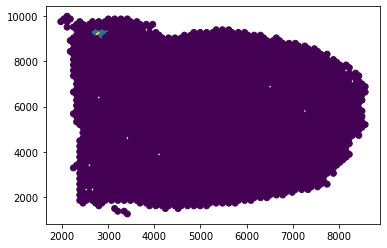

In [14]:
import matplotlib.pyplot as plt
plt.scatter(my_sample.spatialcoord.x, my_sample.spatialcoord.y, c=my_sample.rbf_d[50])

Global Moran's I

In [15]:
%%time
# Global selection of significant pairs
my_sample.spatialdm_global(1000, method='both', select_num=None)  # complete in seconds
my_sample.sig_pairs(method='permutation', fdr=True, threshold=0.1)  # select significant pairs

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5dd09f59d0>
Traceback (most recent call last):
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
100%|██████████| 1000/1000 [01:02<00:00, 16.12it/s]

CPU times: user 1min 3s, sys: 528 ms, total: 1min 3s
Wall time: 1min 2s


Moran's global I per LR across the slide

In [16]:
res = my_sample.global_res

In [17]:
res['global_I'] = my_sample.global_I

In [18]:
res

,ligand,receptor,z_pval,perm_pval,fdr,selected,global_I
TGFB1_TGFBR1_TGFBR2,[Tgfb1],"[Tgfbr1, Tgfbr2]",1.685912e-04,0.000,0.000000,True,0.030023
TGFB2_TGFBR1_TGFBR2,[Tgfb2],"[Tgfbr1, Tgfbr2]",1.668284e-05,0.000,0.000000,True,0.034748
TGFB3_TGFBR1_TGFBR2,[Tgfb3],"[Tgfbr1, Tgfbr2]",9.393182e-03,0.014,0.045081,True,0.019678
TGFB1_ACVR1B_TGFBR2,[Tgfb1],"[Acvr1b, Tgfbr2]",4.893189e-01,0.500,0.783264,False,0.000224
TGFB1_ACVR1C_TGFBR2,[Tgfb1],"[Acvr1c, Tgfbr2]",5.432353e-02,0.072,0.182667,False,0.013436
...,...,...,...,...,...,...,...
THY1_ITGAV_ITGB3,[Thy1],"[Itgav, Itgb3]",4.881027e-05,0.000,0.000000,True,0.032632
ITGA4_ITGB1_VCAM1,"[Itga4, Itgb1]",[Vcam1],3.489889e-12,0.000,0.000000,True,0.057435
ITGA9_ITGB1_VCAM1,"[Itga9, Itgb1]",[Vcam1],3.531991e-15,0.000,0.000000,True,0.065183
ITGA4_ITGB7_VCAM1,"[Itga4, Itgb7]",[Vcam1],1.809730e-01,0.203,0.414527,False,0.007635


In [19]:
res[res.index.str.contains('SEMA4D_PLXNB3')][res.global_I > 0.3].sort_values(by='global_I')

<ipython-input-19-384c796ce143>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res[res.index.str.contains('SEMA4D_PLXNB3')][res.global_I > 0.3].sort_values(by='global_I')


,ligand,receptor,z_pval,perm_pval,fdr,selected,global_I
SEMA4D_PLXNB3,[Sema4d],[Plxnb3],1.360399e-303,0.0,0.0,True,0.311747


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


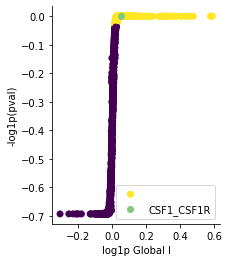

In [20]:
pl.global_plot(my_sample, pairs=['CSF1_CSF1R'])  # Overview of global selection

Re-implement Moran's Global I

1. DataFrame /w L & R 
2. Calulcate L & R means & props (accounting for complexes)
3. Re-implement radial kernel weight
4. Moran's R
5. p-val /w Permutations
6. z-score pvals

In [21]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'spatial_neighbors', 'cluster_nhood_enrichment'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [22]:
from liana.method._pipe_utils._pre import prep_check_adata
from liana.resource import select_resource, explode_complexes
from threadpoolctl import threadpool_limits

In [23]:
from liana.method._pipe_utils import prep_check_adata, filter_resource

In [24]:
from liana.method._liana_pipe import filter_reassemble_complexes

In [25]:
_key_cols = ['ligand_complex', 'receptor_complex']

In [26]:
adata = prep_check_adata(adata, groupby='cluster', min_cells=3)

In [27]:
resource = select_resource('MouseConsensus')

Process Resource

In [28]:
resource = explode_complexes(resource)

In [29]:
resource = filter_resource(resource, adata.var_names)

In [30]:
resource

,interaction,ligand,receptor,ligand_complex,receptor_complex
0,Dll1|Notch1,Dll1,Notch1,Dll1,Notch1
1,Dll1|Notch2,Dll1,Notch2,Dll1,Notch2
2,Dll1|Notch4,Dll1,Notch4,Dll1,Notch4
3,Dll1|Notch3,Dll1,Notch3,Dll1,Notch3
4,Nrg2|Erbb2_Erbb3,Nrg2,Erbb2,Nrg2,Erbb2_Erbb3
...,...,...,...,...,...
5070,Saa2|Grm7,Saa2,Grm7,Saa2,Grm7
5073,Saa1|Scarb1,Saa1,Scarb1,Saa1,Scarb1
5074,Saa2|Scarb1,Saa2,Scarb1,Saa2,Scarb1
5075,Saa1|Tlr2,Saa1,Tlr2,Saa1,Tlr2


Get slide means

In [31]:
entities = np.union1d(np.unique(resource["ligand"]),
                      np.unique(resource["receptor"]))

In [32]:
# Filter to only include the relevant genes
adata = adata[:, np.intersect1d(entities, adata.var.index)]

In [33]:
lr_stats = pd.DataFrame({'means': adata.X.mean(axis=0).A.flatten(), 
                        'props': adata.X.getnnz(axis=0) / adata.X.shape[0]},
                        index=adata.var_names).reset_index().rename(columns={'index': 'gene'})

In [34]:
def _rename_means(lr_stats, entity):
    df = lr_stats.copy()
    df.columns = df.columns.map(lambda x: entity + '_' + str(x) if x!='gene' else 'gene')
    return df.rename(columns = {'gene':entity})

In [35]:
lr_res = resource.merge(_rename_means(lr_stats, entity='ligand')).merge(_rename_means(lr_stats, entity='receptor'))

In [36]:
# # Filter non-expressed
# lr_res = lr_res[(lr_res.ligand_props > 0.05) & (lr_res.receptor_props > 0.05)]

Recomplexify

In [37]:
lr_res = filter_reassemble_complexes(lr_res=lr_res,
                                       _key_cols=_key_cols,
                                       expr_prop=0.05,
                                       complex_cols=['ligand_means', 'receptor_means'])

In [38]:
lr_res[lr_res.interaction.str.contains('Plxnb3')]

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min
1221,Sema5a|Plxnb3,Sema5a,Plxnb3,Sema5a,Plxnb3,0.418452,0.452009,0.190867,0.219866,0.219866
1222,Sema4d|Plxnb3,Sema4d,Plxnb3,Sema4d,Plxnb3,0.544131,0.524554,0.190867,0.219866,0.219866
1223,Sema4a|Plxnb3,Sema4a,Plxnb3,Sema4a,Plxnb3,0.296781,0.383557,0.190867,0.219866,0.219866


For now I will use their spatial kernel weights

In [39]:
rbf_d = my_sample.rbf_d

In [40]:
# every spot to every spot:
my_sample.rbf_d.shape[0]

2688

(Vectorized) For all interactions:

norm expr mat - i.e. (x - x^) & (y - y^)

In [41]:
norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0)))
sqrt_a = np.sqrt(np.sum(np.power(norm_mat, 2), axis=0)).T

In [42]:
ligand_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
              in lr_res['ligand']}
receptor_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
                in lr_res['receptor']}

Calculate Global Moran's R

Ligand Cube x Receptor matrix

In [43]:
import scipy
from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF

In [44]:
# essential for this to be sparse
dist = scipy.sparse.csr_matrix(my_sample.rbf_d)

In [45]:
norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0))) # normalized x matrix

In [46]:
norm_mat = norm_mat / np.sqrt(np.sum(norm_mat**2, axis=0, keepdims=True))

In [47]:
# sqrt_a = np.sqrt(np.sum(np.power(norm_mat, 2), axis=0)).T # sqrt matrix
# positions
ligand_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
              in lr_res['ligand']}
receptor_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
                in lr_res['receptor']}

In [48]:
n_perm = 1000

In [49]:
ligand_mat = np.array([norm_mat[:, ligand_pos[ligand]] for ligand in lr_res.ligand])
receptor_mat = np.array([norm_mat[:, receptor_pos[receptor]] for receptor in lr_res.receptor])
# ligand_sqrt = np.array([sqrt_a[ligand_pos[ligand]] for ligand in lr_res.ligand])
# receptor_sqrt = np.array([sqrt_a[receptor_pos[receptor]] for receptor in lr_res.receptor])

global_r for all

In [50]:
global_r = ((ligand_mat @ dist)* receptor_mat).sum(axis=1)

In [51]:
lr_res['global_r'] = global_r

Create a perm_matrix for all LRs

Permutation p-vals

In [52]:
rng = np.random.default_rng()

In [53]:
idx = norm_mat.shape[0]

In [54]:
# mat /w n_perms x LR_n
perm_mat = np.zeros((n_perm, global_r.shape[0]))

In [55]:
%%time
for perm in tqdm(range(n_perm)):
    _idx = rng.permutation(idx)
    perm_mat[perm,:] = ((ligand_mat[:, _idx] @ dist) * receptor_mat).sum(axis=1)

100%|██████████| 1000/1000 [00:46<00:00, 21.32it/s]

CPU times: user 47 s, sys: 54.3 ms, total: 47 s
Wall time: 46.9 s


In [56]:
global_pvals = 1 - (global_r > perm_mat).sum(axis=0)/n_perm

In [57]:
lr_res['global_pvals'] = global_pvals

Z-score p-vals

In [58]:
from scipy import stats

In [59]:
dist = np.array(dist.todense())

In [60]:
# global distance variance (~copy pasted)
n = adata.shape[0]
nm = (n ** 2 * (dist * dist).sum()) - (2 * n * (dist.sum(axis=1) * dist.sum(axis=0)).sum()) + (dist.sum() ** 2)
dm = n ** 2 * (n - 1) ** 2

In [61]:
# squered variance
dist_var = nm/dm  # aka st

In [62]:
dist_var_sq = dist_var ** (1 / 2)

In [63]:
dist_var_sq

0.00837473813175262

In [64]:
global_zscores = global_r / dist_var_sq

In [65]:
global_zpvals = stats.norm.sf(global_zscores)

In [66]:
# assign to LR
lr_res['global_zscores'] = global_zscores

In [67]:
lr_res['global_zpvals'] = global_zpvals

Compare global

In [68]:
lr_res.interaction = lr_res.interaction.str.upper()
lr_res.interaction = lr_res.interaction.str.replace('|', '_')

<ipython-input-68-b09654ff13ad>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [69]:
res = res.reset_index().rename(columns={'index':'interaction'})

In [70]:
res = res[[len(rec) < 2 for rec in res.receptor]]

In [71]:
joined = lr_res.merge(res, on='interaction')

In [72]:
joined

,interaction,ligand_x,receptor_x,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,...,global_pvals,global_zscores,global_zpvals,ligand_y,receptor_y,z_pval,perm_pval,fdr,selected,global_I
0,DLL1_NOTCH1,Dll1,Notch1,Dll1,Notch1,0.037283,0.057292,0.216689,0.276786,0.057292,...,0.121,1.228862,1.095617e-01,[Dll1],[Notch1],1.095618e-01,0.130,0.297284,False,0.010291
1,JAG1_NOTCH1,Jag1,Notch1,Jag1,Notch1,0.051299,0.075893,0.216689,0.276786,0.075893,...,0.624,-0.287137,6.129963e-01,[Jag1],[Notch1],6.129979e-01,0.609,0.895379,False,-0.002405
2,DLK1_NOTCH1,Dlk1,Notch1,Dlk1,Notch1,0.236641,0.213542,0.216689,0.276786,0.213542,...,0.990,-2.400463,9.918128e-01,[Dlk1],[Notch1],9.918127e-01,0.988,1.000000,False,-0.020103
3,DLL3_NOTCH1,Dll3,Notch1,Dll3,Notch1,0.108551,0.161086,0.216689,0.276786,0.161086,...,0.982,-2.322272,9.898909e-01,[Dll3],[Notch1],9.898906e-01,0.988,1.000000,False,-0.019448
4,JAG2_NOTCH1,Jag2,Notch1,Jag2,Notch1,0.273678,0.364583,0.216689,0.276786,0.276786,...,1.000,-4.523731,9.999970e-01,[Jag2],[Notch1],9.999970e-01,1.000,1.000000,False,-0.037885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,ENTPD1_ADORA1,Entpd1,Adora1,Entpd1,Adora1,0.089811,0.128720,0.846592,0.736979,0.128720,...,0.386,0.517597,3.023697e-01,[Entpd1],[Adora1],3.023686e-01,0.387,0.657507,False,0.004335
219,PSAP_GPR37,Psap,Gpr37,Psap,Gpr37,3.318095,0.999628,0.798705,0.622396,0.622396,...,1.000,-22.599236,1.000000e+00,[Psap],[Gpr37],1.000000e+00,1.000,1.000000,False,-0.189263
220,PSAP_GPR37L1,Psap,Gpr37l1,Psap,Gpr37l1,3.318095,0.999628,1.765455,0.977307,0.977307,...,1.000,-19.868069,1.000000e+00,[Psap],[Gpr37l1],1.000000e+00,1.000,1.000000,False,-0.166390
221,TAC1_TACR1,Tac1,Tacr1,Tac1,Tacr1,0.364385,0.326637,0.046681,0.070685,0.070685,...,0.000,20.172024,8.621802e-91,[Tac1],[Tacr1],8.611413e-91,0.000,0.000000,True,0.168936


In [73]:
import scipy

In [74]:
joined

,interaction,ligand_x,receptor_x,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,...,global_pvals,global_zscores,global_zpvals,ligand_y,receptor_y,z_pval,perm_pval,fdr,selected,global_I
0,DLL1_NOTCH1,Dll1,Notch1,Dll1,Notch1,0.037283,0.057292,0.216689,0.276786,0.057292,...,0.121,1.228862,1.095617e-01,[Dll1],[Notch1],1.095618e-01,0.130,0.297284,False,0.010291
1,JAG1_NOTCH1,Jag1,Notch1,Jag1,Notch1,0.051299,0.075893,0.216689,0.276786,0.075893,...,0.624,-0.287137,6.129963e-01,[Jag1],[Notch1],6.129979e-01,0.609,0.895379,False,-0.002405
2,DLK1_NOTCH1,Dlk1,Notch1,Dlk1,Notch1,0.236641,0.213542,0.216689,0.276786,0.213542,...,0.990,-2.400463,9.918128e-01,[Dlk1],[Notch1],9.918127e-01,0.988,1.000000,False,-0.020103
3,DLL3_NOTCH1,Dll3,Notch1,Dll3,Notch1,0.108551,0.161086,0.216689,0.276786,0.161086,...,0.982,-2.322272,9.898909e-01,[Dll3],[Notch1],9.898906e-01,0.988,1.000000,False,-0.019448
4,JAG2_NOTCH1,Jag2,Notch1,Jag2,Notch1,0.273678,0.364583,0.216689,0.276786,0.276786,...,1.000,-4.523731,9.999970e-01,[Jag2],[Notch1],9.999970e-01,1.000,1.000000,False,-0.037885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,ENTPD1_ADORA1,Entpd1,Adora1,Entpd1,Adora1,0.089811,0.128720,0.846592,0.736979,0.128720,...,0.386,0.517597,3.023697e-01,[Entpd1],[Adora1],3.023686e-01,0.387,0.657507,False,0.004335
219,PSAP_GPR37,Psap,Gpr37,Psap,Gpr37,3.318095,0.999628,0.798705,0.622396,0.622396,...,1.000,-22.599236,1.000000e+00,[Psap],[Gpr37],1.000000e+00,1.000,1.000000,False,-0.189263
220,PSAP_GPR37L1,Psap,Gpr37l1,Psap,Gpr37l1,3.318095,0.999628,1.765455,0.977307,0.977307,...,1.000,-19.868069,1.000000e+00,[Psap],[Gpr37l1],1.000000e+00,1.000,1.000000,False,-0.166390
221,TAC1_TACR1,Tac1,Tacr1,Tac1,Tacr1,0.364385,0.326637,0.046681,0.070685,0.070685,...,0.000,20.172024,8.621802e-91,[Tac1],[Tacr1],8.611413e-91,0.000,0.000000,True,0.168936


In [75]:
scipy.stats.pearsonr(joined.fdr,  joined.global_pvals)

(0.9662341158895071, 3.868631603794239e-132)

In [76]:
scipy.stats.pearsonr(joined.z_pval,  joined.global_zpvals)

(0.9999999999958277, 0.0)

Local Moran's I

In [77]:
dist = scipy.sparse.csr_matrix(my_sample.rbf_d)

In [78]:
norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0))) # normalized x matrix
# Note here - there is no normalisation by the squares

In [79]:
ligand_mat = np.array([norm_mat[:, ligand_pos[ligand]] for ligand in lr_res.ligand]).T
receptor_mat = np.array([norm_mat[:, receptor_pos[receptor]] for receptor in lr_res.receptor]).T

In [80]:
# calculate both sides for local_Rs
local_x = ligand_mat * (dist @ receptor_mat) # local_I
local_y = receptor_mat * (dist @ ligand_mat) # local_I_R

Permutations

In [81]:
# also only sig on global (i.e. only positive by default)?
lr_msk = global_pvals <= 0.05

In [82]:
# he used to filter spot to spot to be positive
# i guess to exclude - to - positive correlations (does this even make sense...)

In [83]:
local_x = local_x[:, lr_msk]
local_y = local_y[:, lr_msk]
assert local_x.shape == local_y.shape

In [84]:
receptor_mat = receptor_mat[:, lr_msk]
ligand_mat = ligand_mat[:, lr_msk]

In [85]:
spot_n = local_x.shape[0]
lr_n = local_x.shape[1]
n_perm = 100

In [86]:
perm_x = np.zeros((lr_n, n_perm, spot_n))
perm_y = np.zeros((lr_n, n_perm, spot_n))

In [87]:
for i in tqdm(range(n_perm)):
    _idx = np.random.permutation(ligand_mat.shape[0])
    perm_x[:, i,:] = ((dist @ receptor_mat[_idx, :]) * ligand_mat).T
    perm_y[:, i,:] = ((dist @ ligand_mat[_idx, :]) * receptor_mat).T


100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


In [88]:
local_pvals = ((np.expand_dims(local_x.T + local_y.T, 1) <= (perm_x + perm_y)).sum(1)) / n_perm

In [89]:
local_r = local_x + local_y # actual value
local_pvals

array([[0.61, 0.34, 0.8 , ..., 0.27, 0.19, 0.32],
       [0.36, 0.55, 0.68, ..., 0.05, 0.21, 0.87],
       [0.6 , 0.15, 1.  , ..., 0.28, 0.79, 0.18],
       ...,
       [0.11, 0.73, 0.23, ..., 0.32, 0.1 , 0.89],
       [0.82, 0.79, 0.29, ..., 0.03, 0.51, 0.28],
       [0.01, 0.03, 0.  , ..., 0.01, 0.92, 0.37]])

zscore p-val

In [90]:
from scipy import stats

In [144]:
dist = scipy.sparse.csr_matrix(my_sample.rbf_d)
wij_sq = (np.array(dist.todense()) ** 2).sum(axis=1)

In [145]:
norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0))) # normalized x matrix
# Note here - there is no normalisation by the squares

In [146]:
ligand_mat = np.array([norm_mat[:, ligand_pos[ligand]] for ligand in lr_res.ligand]).T
receptor_mat = np.array([norm_mat[:, receptor_pos[receptor]] for receptor in lr_res.receptor]).T

In [158]:
# pos = (L_mat > 0) + (R_mat > 0)

In [147]:
# calculate both sides for local_Rs
local_x = ligand_mat * (dist @ receptor_mat) # local_I
local_y = receptor_mat * (dist @ ligand_mat) # local_I_R

In [148]:
ligand_norm = np.array([stats.norm.fit(ligand_mat[:, ligand]) for ligand in range(ligand_mat.shape[1])])
receptor_norm = np.array([stats.norm.fit(receptor_mat[:, receptor]) for receptor in range(receptor_mat.shape[1])])

In [149]:
# get ligand receptor mu and std
ligand_mu1, ligand_std = ligand_norm[:,0], ligand_norm[:,1]
receptor_mu1, receptor_std = receptor_norm[:,0], receptor_norm[:,1]

In [150]:
ligand_sigma_sq = [(std * spot_n / (spot_n - 1)) for std in ligand_std]
receptor_sigma_sq = [(std * spot_n / (spot_n - 1)) for std in receptor_std]

In [151]:
def compute_var_local(sigma1_sq, sigma2_sq, wij_sq, spot_n):
    var_I = 2 * (spot_n-1)**2/spot_n**2 * sigma1_sq * sigma2_sq * wij_sq + \
        2 * (spot_n-1)**2/spot_n**2 * sigma1_sq * sigma2_sq
    std_I=var_I**(1/2)
    
    return std_I

In [155]:
std_ls = [compute_var_local(sigma1_sq, sigma2_sq, wij_sq, spot_n) for (sigma1_sq, sigma2_sq) in zip(ligand_sigma_sq, receptor_sigma_sq)]

In [164]:
local_zscores = local_x.T + local_y.T / std_ls

In [168]:
local_zscores.shape

(1409, 2688)

In [97]:
receptor_mat.shape

(2688, 1409)

In [98]:
mu1_ls, std_L_ls = norm_res1[:,0], norm_res1[:,1]
mu2_ls, std_R_ls = norm_res2[:,0], norm_res2[:,1]
sigma1_sq_ls = [(std1 * N / (N - 1)) for std1 in std_L_ls]
sigma2_sq_ls = [(std2 * N / (N - 1)) for std2 in std_R_ls]


NameError: name 'norm_res1' is not defined

In [ ]:
std_ls = [compute_var_local(sigma1_sq, sigma2_sq, wij_sq, N) \
                    for (sigma1_sq, sigma2_sq) in zip(sigma1_sq_ls, sigma2_sq_ls)]

In [ ]:
std_ls = [compute_var_local(sigma1_sq, sigma2_sq, wij_sq, N) \
            for (sigma1_sq, sigma2_sq) in zip(sigma1_sq_ls, sigma2_sq_ls)]
adata.uns['local_z'] = (adata.uns['local_stat']['local_I'] + \
                                      adata.uns['local_stat']['local_I_R']).T / std_ls
adata.uns['local_z_p'] = stats.norm.sf(adata.uns['local_z'])
#adata.uns['local_z_p'] = np.where(pos.T == False, 1, adata.uns['local_z_p'])
adata.uns['local_z_p'] = pd.DataFrame(adata.uns['local_z_p'], index=ind)

In [87]:
# dist_sq
wij_sq = (np.array(dist.todense()) ** 2).sum(axis=1)

Compare local

In [108]:
# Local selection of significant spots
my_sample.spatialdm_local(n_perm=10, method='both', select_num=None, nproc=1)     # local spot selection complete in seconds

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5d20c53280>
Traceback (most recent call last):
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
100%|██████████| 10/10 [00:00<00:00, 31.87it/s]


In [109]:
# keep only sig hits from global?
my_sample.local_I.shape

(2688, 544)

In [110]:
my_sample

In [112]:
my_sample.sig_spots(threshold=0.1)     # significant local spots

In [115]:
my_sample.local_z_p

,0,1,2,3,4,5,6,7,8,9,...,2678,2679,2680,2681,2682,2683,2684,2685,2686,2687
TGFB1_TGFBR1_TGFBR2,0.515013,1.000000,0.601061,0.516664,0.505532,0.524936,0.512647,1.000000,0.516496,0.690327,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.491905,1.000000,0.505979,1.000000
TGFB2_TGFBR1_TGFBR2,0.526429,1.000000,0.475422,0.536976,0.519828,0.505607,0.085577,1.000000,0.360034,0.807048,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.538961,1.000000,1.000000,1.000000
TGFB3_TGFBR1_TGFBR2,0.520457,1.000000,0.476562,0.511573,0.507540,0.513354,0.378390,1.000000,0.268157,0.750814,...,1.000000,1.000000,1.000000,0.575516,1.000000,0.586401,0.424065,1.000000,0.495909,1.000000
TGFB2_ACVR1C_TGFBR2,1.000000,1.000000,0.492407,0.650035,0.100044,1.000000,0.909662,0.590025,0.564324,0.709203,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.526002,0.554341,1.000000,0.608964,1.000000
TGFB3_ACVR1C_TGFBR2,1.000000,1.000000,0.493603,0.539416,0.662756,0.688612,0.611018,0.528271,0.610661,0.664898,...,1.000000,1.000000,1.000000,0.649047,1.000000,0.514248,0.401813,1.000000,0.245766,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEMA6B_PLXNA4,0.512348,0.502974,0.285016,1.000000,0.654157,0.310702,0.000054,0.029878,0.364353,0.534835,...,1.000000,1.000000,0.649617,0.286871,0.529865,0.420959,0.485978,0.486448,0.766609,0.469716
THY1_ITGAV_ITGB3,0.306624,0.068972,0.625763,0.254803,0.875626,0.496420,0.116117,0.060226,0.527041,0.086659,...,0.008673,0.591412,0.535250,0.999876,0.754092,0.349596,0.308348,0.032318,0.135649,0.698340
ITGA4_ITGB1_VCAM1,1.000000,0.606484,0.498298,1.000000,0.475556,0.468129,0.071633,0.536333,0.494243,0.497945,...,0.502390,0.501711,0.469548,0.558246,1.000000,0.448747,0.497481,0.437814,1.000000,1.000000
ITGA9_ITGB1_VCAM1,1.000000,0.616200,0.537780,1.000000,0.489528,0.498225,0.307155,0.481645,0.563987,0.493906,...,0.492152,0.496248,0.446286,0.569571,1.000000,0.427187,0.508269,0.384843,1.000000,1.000000


In [234]:
# only keeps sig local interactions?

In [226]:
my_sample.local_I.shape

(2688, 545)

In [117]:
?pl.plot_pairs

Signature:
pl.plot_pairs(
    sample,
    pairs_to_plot,
    pdf=None,
    figsize=(35, 5),
    cmap='Greens',
    cmap_l='coolwarm',
    cmap_r='coolwarm',
    **kwargs,
)
Docstring:
plot selected spots as well as LR expression.
:param pairs_to_plot: list or arrays. pair name(s), should be from spatialdm_local pairs .
:param pdf: str. pdf file prefix. save plots in a pdf file.
:param figsize: figsize for each pair. Default to (35, 5).
:param markersize: markersize for each spot. Default
:param cmap: cmap for selected local spots.
:param cmap_l: cmap for selected ligand. If None, no subplot for ligand expression.
:param cmap_r: cmap for selected receptor. If None, no subplot for receptor expression
:return:
File:      ~/anaconda3/lib/python3.8/site-packages/spatialdm/plottings.py
Type:      function


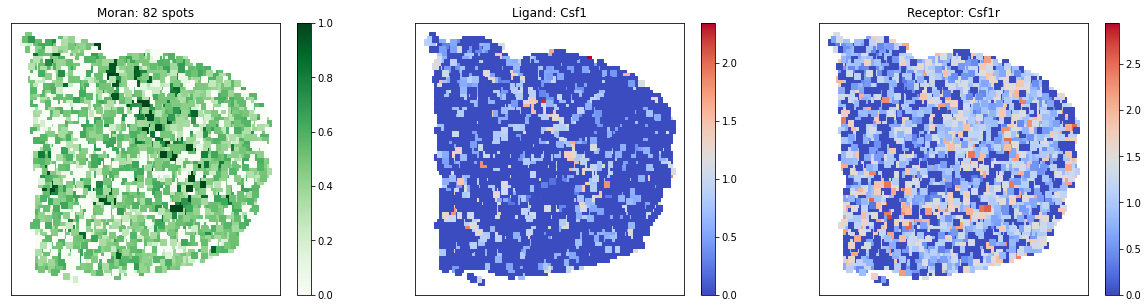

In [116]:
pl.plot_pairs(my_sample, ['CSF1_CSF1R'], marker='s') # visualize known melanoma pair(s)